Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Vector Quantized Generative Adversarial Networks with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a Vector Quantized Generative Adversarial Network (VQGAN) on 2D images.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch.nn import L1Loss

from monai import transforms as mt
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism, ensure_tuple
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.networks.nets import VQVAE, PatchDiscriminator

print_config()

MONAI version: 1.4.0rc6
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6a0e1b043ba2890e1463fa49df76f66e56a68b08
MONAI __file__: /home/<username>/miniconda3/envs/monai/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.0
pynrrd version: 1.0.0
clearml version: 1.16.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp841jzn7l


## Set deterministic training for reproducibility

In [3]:
set_determinism(42)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("HeadCT").

In [4]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]

2024-09-05 22:01:10,924 - INFO - Downloaded: /tmp/tmp841jzn7l/MedNIST.tar.gz
2024-09-05 22:01:11,062 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-05 22:01:11,063 - INFO - Writing into directory: /tmp/tmp841jzn7l.


Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [5]:
batch_size = 16

train_transforms = mt.Compose(
    [
        mt.LoadImaged(keys=["image"]),
        mt.EnsureChannelFirstd(keys=["image"]),
        mt.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        mt.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

Loading dataset: 100%|██████████| 7991/7991 [00:06<00:00, 1264.77it/s]


In [6]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
val_transforms = mt.Compose(
    [
        mt.LoadImaged(keys=["image"]),
        mt.EnsureChannelFirstd(keys=["image"]),
        mt.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

2024-09-05 22:01:43,022 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-05 22:01:43,023 - INFO - File exists: /tmp/tmp841jzn7l/MedNIST.tar.gz, skipped downloading.
2024-09-05 22:01:43,025 - INFO - Non-empty folder exists in /tmp/tmp841jzn7l/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 972/972 [00:00<00:00, 1342.56it/s]


### Visualization of the training images

batch shape: torch.Size([256, 1, 64, 64])


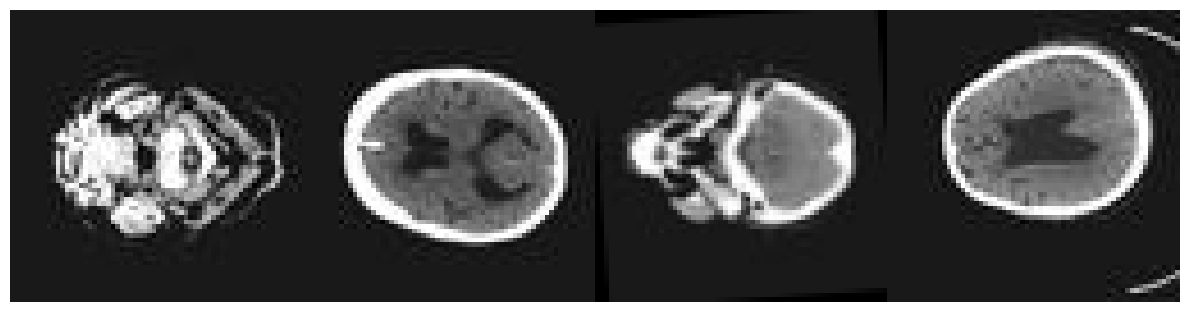

In [7]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualization = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualization, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler and optimizer
At this step, we instantiate the MONAI components to create a VQVAE and a Discriminator model. We are using the
Discriminator to train the Autoencoder with a Generative Adversarial loss, where the VQVAE works as a Generator.
The VQVAE is trained to minimize the reconstruction error, a perceptual loss using AlexNet as the embedding model
and an adversarial loss versus the performance of the Discriminator.

In [10]:
device = torch.device("cuda")

model = VQVAE(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(256, 512),
    num_res_channels=512,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    num_embeddings=256,
    embedding_dim=32,
).to(device)

discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, channels=64)
discriminator.to(device)

perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)

optimizer_g = torch.optim.Adam(params=model.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=5e-4)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.


In [11]:
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

### Model training
Here, we are training our model for 100 epochs (training time: ~50 minutes).

In [12]:
max_epochs = 100
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        # Generator part
        reconstruction, quantization_loss = model(images=images)
        logits_fake = discriminator(reconstruction.contiguous().float())[-1]

        recons_loss = l1_loss(reconstruction.float(), images.float())
        p_loss = perceptual_loss(reconstruction.float(), images.float())
        generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
        loss_g = recons_loss + quantization_loss + perceptual_weight * p_loss + adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        # Discriminator part
        optimizer_d.zero_grad(set_to_none=True)

        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = discriminator(images.contiguous().detach())[-1]
        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

        loss_d = adv_weight * discriminator_loss

        loss_d.backward()
        optimizer_d.step()

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                reconstruction, quantization_loss = model(images=images)

                # get the first sammple from the first validation batch for visualization
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 2: 100%|███████████| 32/32 [00:22<00:00,  1.42it/s, recons_loss=0.0514, gen_loss=0.686, disc_loss=0.312]
...
Epoch 99: 100%|██████████| 32/32 [00:22<00:00,  1.42it/s, recons_loss=0.0206, gen_loss=0.285, disc_loss=0.254]


train completed, total time: 2268.8532989025116.


### Learning curves

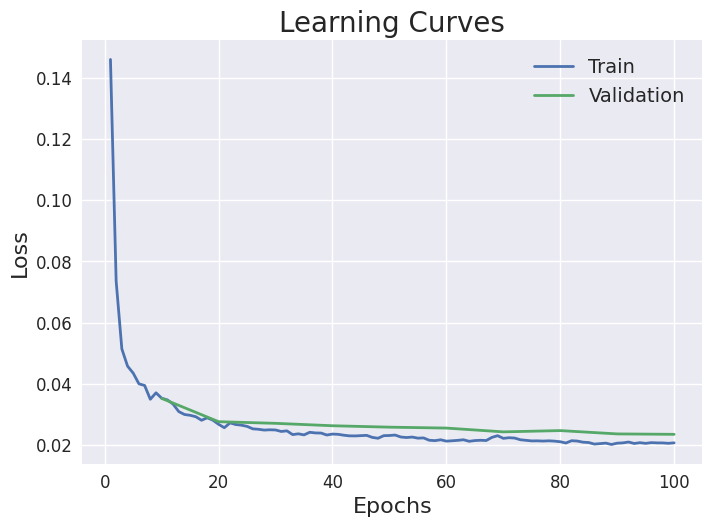

In [13]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

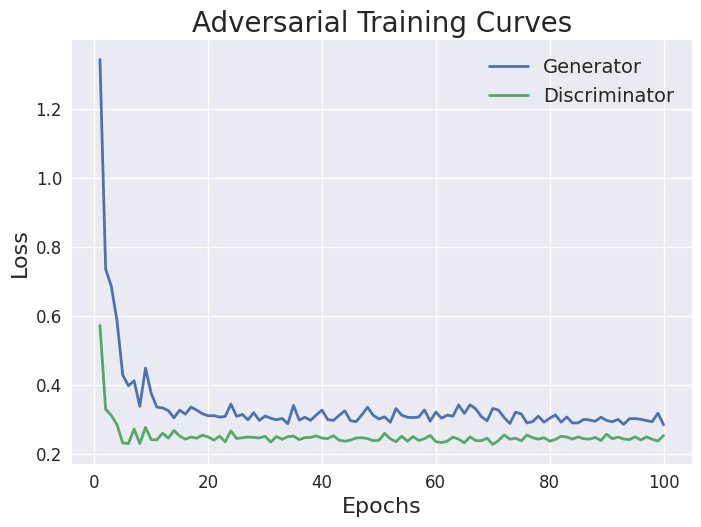

In [14]:
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Checking reconstructions

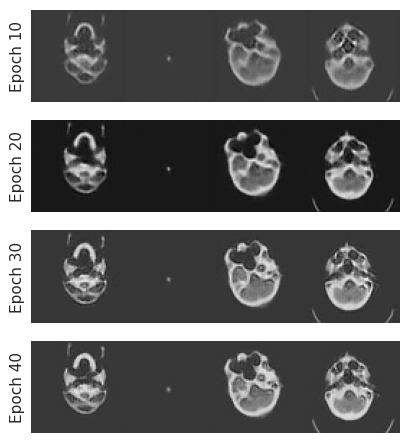

In [15]:
# Plot first 4 evaluations
val_samples = np.linspace(val_interval, max_epochs, int(max_epochs / val_interval))
num_inters = min(len(intermediary_images), 4)
fig, ax = plt.subplots(nrows=num_inters, ncols=1, sharey=True)
ax = ensure_tuple(ax)

for image_n in range(num_inters):
    reconstructions = torch.reshape(intermediary_images[image_n], (64 * n_example_images, 64)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

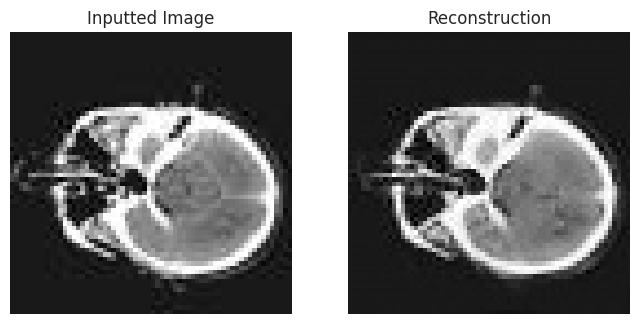

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [17]:
if directory is None:
    shutil.rmtree(root_dir)